# 5. 검색 및 추천 프로그램

In [ ]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

# 5-1 워드클라우드 준비(설치)

In [ ]:
## Mecab 설치

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

In [ ]:
stopwords1 = pd.read_csv('/content/drive/MyDrive/도서추천시스템/data/전처리 및 EDA/한국어불용어.txt', sep = '\t', header = 0)
stopwords=[]
for i in stopwords1['1']:
    stopwords.append(i)

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
book1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/book1_drop.pkl')
book1 = book1[['isbn13','author','text']]
book1.columns = ['isbn','author','text']
book1.head(2)

,isbn,author,text
0,9791190710343,버지니아 울프,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,9791190710350,제인 오스틴,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."


In [ ]:
# colab 폰트 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
re = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new_pred.pkl')
re = re.reset_index()
re = re.drop(columns = 'index')
re.head()

,level_0,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
0,0,9791165341909,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,소설,379054,False,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]",8.0
1,1,9791161571188,불편한 편의점 (40만부 기념 벚꽃 에디션),소설,330837,False,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]",10.0
2,2,9791192186313,시맨틱 에러 포토에세이,에세이,242520,False,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]",10.0
3,3,9788954681179,밝은 밤 (별밤 에디션),소설,204554,False,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]",10.0
4,4,9791165343729,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,소설,191493,False,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]",9.0


In [ ]:
books_all = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/books_all.pkl')
books_all = books_all[['isbn','rank_mean', 'review_title', 'review_id', 'review_rank',
        'review_text', 'rank_percentage']]
books_all.head(2)

,isbn,rank_mean,review_title,review_id,review_rank,review_text,rank_percentage
0,9791190710343,9.4,자기만의 방 - 버지니아 울프의 여성에세이,s*****0,5.0,\n\n \n시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 <자기만의 방>은...,"[67%, 33%, 0%, 0%, 0%]"
1,9791190710343,9.4,#여성에세이#자기만의 방,녹**다,5.0,\n\n \n자기만의 방 버지니아 울프의 작품이다.한시대를 살다간 그녀의 삶은 기발...,"[67%, 33%, 0%, 0%, 0%]"


# 5-2 검색 함수

In [ ]:
# 관심있는 것
def category(카테고리):
    if 카테고리[0][0] != '선택없음':
        return (re['categoryName'][i] in 카테고리[0])
    else:
        return True

def genresand(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) & (장르[0][1] in re['genres'][i])


def moodand(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) & (감성[0][1] in re['mood'][i])

def interestand(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) & (관심사[0][1] in re['interest'][i])
    
def genresor(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) | (장르[0][1] in re['genres'][i])


def moodor(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) | (감성[0][1] in re['mood'][i])

def interestor(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) | (관심사[0][1] in re['interest'][i])

In [ ]:
# 관심없는 것

def nogenresand(장르no):
    if 장르no[0][0] == '선택없음':
        return True
    elif (len(장르no[0]) == 1):
        return (장르no[0][0] not in re['genres'][i])
    elif (len(장르no[0]) == 2):
        return (장르no[0][0] not in re['genres'][i]) & (장르no[0][1] not in re['genres'][i])


def nomoodand(감성no):
    if 감성no[0][0] == '선택없음':
        return True
    elif (len(감성no[0]) == 1):
        return (감성no[0][0] not in re['mood'][i])
    elif (len(감성no[0]) == 2):
        return (감성no[0][0] not in re['mood'][i]) & (감성no[0][1] not in re['mood'][i])

def nointerestand(관심사no):
    if 관심사no[0][0] == '선택없음':
        return True
    elif (len(관심사no[0]) == 1):
        return (관심사no[0][0] not in re['interest'][i])
    elif (len(관심사no[0]) == 2):
        return (관심사no[0][0] not in re['interest'][i]) & (관심사no[0][1] not in re['interest'][i])

# 5-3 협업필터링_1 함수

In [ ]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # P와 Q 매트릭스를 계속 업데이트(확률적 경사하강법)
    for step in tqdm_notebook(range(steps)):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

# 5-4 협업필터링_2 함수
(userid에 추천)

In [ ]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 도서명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 도서명을 list 객체로 만듬. 
    books_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 book은 books_list에서 제외함. 
    unseen_list = [ book for book in books_list if book not in already_seen]
    
    return unseen_list

In [ ]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    # loc[행:열] 데이터 찾아, top_n 까지 내림차순으로 정렬
    return recomm_books

# 5-5. 프로그램 실행

Q1. 회원이십니까? : 네 / 아니요
아니요

Q2. 성인입니까? : 네 / 아니요
네

Q3. 원하시는 분야를 입력해주세요 : 
소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음
소설 에세이

Q4-1. 책을 읽을 때 선호하는 장르가 있나요? : 
시대 / 역사 / 철학 / 로맨스 / 전쟁 / 미스터리 / 예술 / 판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음
로맨스 예술

Q4-2. 원하지 않는 장르를 입력해주세요 : 
전쟁

Q5-1. 어떤 감성의 책을 원하세요? : 
고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /                    
희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음
선택없음

Q5-2. 원하지 않는 감성을 입력해주세요 : 
고통 비극

Q6-1. 요즘 관심있는 것이 무엇인가요? : 
리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /                    
가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /                    
종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음
사랑

Q6-2. 원하지 않는 관심사를 입력해주세요 : 
선택없음


------------------ 답변을 바탕으로 추천 도서를 선정하는 중입니다 ----------------------------

Wall time: 0 ns
Wall time: 0 ns


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.855488303314752
### iteration step :  10  rmse :  4.759788480269303
### iteration step :  20  rmse :  3.2337985406914176
### iteration step :  30  rmse :  1.2501728728295676
### iteration step :  40  rmse :  0.6892468595822829
### iteration step :  50  rmse :  0.38938099770544254
### iteration step :  60  rmse :  0.24268895299168822
### iteration step :  70  rmse :  0.13980540776508413
### iteration step :  80  rmse :  0.07439633387004708
### iteration step :  90  rmse :  0.044259618260661965
### iteration step :  100  rmse :  0.03203640866597473
### iteration step :  110  rmse :  0.02624831742724513
### iteration step :  120  rmse :  0.022953417186716337
### iteration step :  130  rmse :  0.020897321910995633
### iteration step :  140  rmse :  0.019541745718037136
### iteration step :  150  rmse :  0.01860044598074918
### iteration step :  160  rmse :  0.017912994801085953
### iteration step :  170  rmse :  0.017388924785459472
### iteration step :  

C:\Users\user\AppData\Local\Temp/ipykernel_13500/590315765.py:175: FutureWarning: The default value of regex will change from True to False in a future version.
  word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')




------------------ 추천된 도서를 정렬하는 중입니다 ----------------------------



,title,author,categoryName,genres,mood,interest
0,밝은 밤 (별밤 에디션),최은영,소설,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]"
1,펠리시아의 여정,윌리엄 트레버,소설,"[예술, 동화, 로맨스]","[행복, 열정, 슬픔, 긍정, 위로, 희망, 열망, 용기, 절망]","[생각, 사랑, 인생, 청춘, 여행, 인간]"
2,너 없이 걸었다 - 뮌스터,허수경,에세이,"[예술, 동화]","[용기, 행복, 열정, 후회]","[시간, 생각, 사랑, 인생, 청춘, 시, 인간, 친구]"
3,모래알만 한 진실이라도 (여우눈 에디션) - 박완서 에세이 결정판,박완서,에세이,"[예술, 동화]","[행복, 위로]","[사랑, 생각, 취미, 일상]"
4,잠중록 3,처처칭한,소설,"[역사, 로맨스, 판타지, 미스터리, 무협]","[행복, 위로]","[가족, 심리, 관계, 일기, 영화, 사랑, 생각]"
5,이 세계에서 너와 두 번째 첫사랑을,모치즈키 쿠라게,소설,"[로맨스, 판타지, 동화]","[위로, 행복, 열정, 후회]","[사랑, 청춘, 생각, 인생, 일기, 설득, 친구]"
6,H마트에서 울다,미셸 자우너,에세이,[예술],"[열정, 행복, 긍정]","[음악, 사랑, 인생, 청춘, 가족, 음식, 생각, 건강]"
7,"그냥, 그렇다고 - 그냥 사람 사는 이야기",짧은대본,에세이,"[동화, 로맨스]","[힐링, 위로, 행복, 열정, 후회]","[심리, 관계, 사진, 그림, 영화, 사랑, 생각, 인생, 청춘, 친구]"
8,메시지를 입력하세요,오휘명,소설,"[로맨스, 동화]","[행복, 위로, 희망, 열정, 후회, 용기]","[사랑, 생각, 인생, 청춘, 관계, 시간, 친구]"


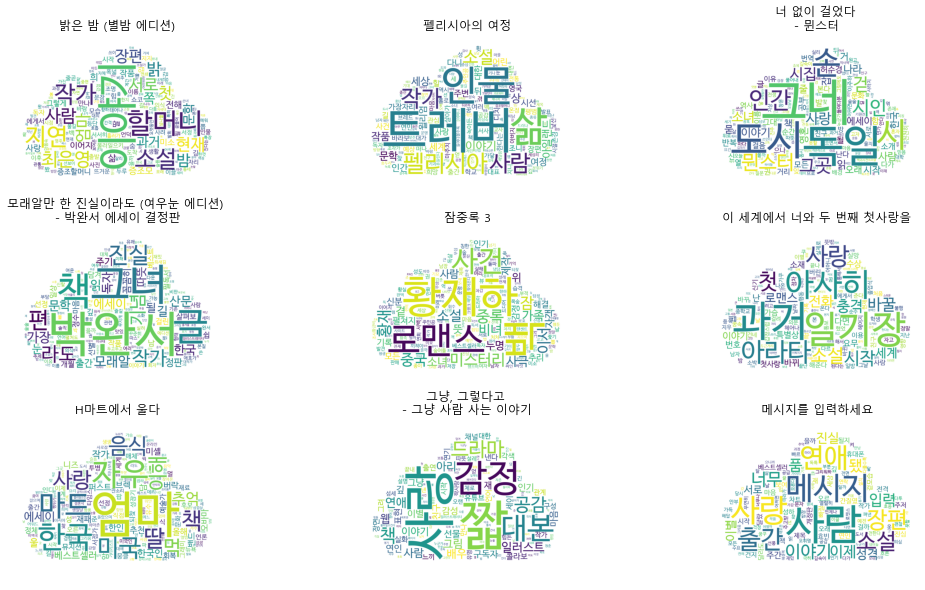

In [ ]:
# 1. 검색 --------------------------------------------------------------------------------------------
카테고리 = []
장르 = []
감성 = []
관심사 = []
성인 = []
장르no = []
감성no = []
관심사no = []
성인no = []
userid = []

userid질문 = input('Q1. 회원이십니까? : 네 / 아니요\n')
if userid질문 == '네':
    userid.append(input('\nQ1-1. 아이디를 입력해주세요 : \n'))
    성인질문 = input('\nQ2. 성인입니까? : 네 / 아니요\n')
else:
    성인질문 = input('\nQ2. 성인입니까? : 네 / 아니요\n')

if 성인질문 == '네':
    성인.append([True,False])
    카테고리.append(input("\nQ3. 원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\nQ4-1. 책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 / 미스터리 / 예술 / 판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\nQ4-2. 원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\nQ5-1. 어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\nQ5-2. 원하지 않는 감성을 입력해주세요 : \n').split())
    관심사.append(input('\nQ6-1. 요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\nQ6-2. 원하지 않는 관심사를 입력해주세요 : \n').split())
elif 성인질문 == '아니요':
    성인.append([False])
    카테고리.append(input("\nQ3. 원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\nQ4-1. 책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 / 미스터리 / 예술 / 판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\nQ4-2. 원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\nQ5-1. 어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\nQ5-2. 원하지 않는 감성을 입력해주세요 : \n').split())
    관심사.append(input('\nQ6-1. 요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\nQ6-2. 원하지 않는 관심사를 입력해주세요 : \n').split())

time.sleep(1)
print()
time.sleep(1)
print('\n------------------ 답변을 바탕으로 추천 도서를 선정하는 중입니다 ----------------------------\n')

select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

%time
# 2. 가중평점 --------------------------------------------------------------------------------------------

# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['rank_pred'].mean()
m = re['salesPoint'].quantile(0.6)

def weighted_score_average(record):
    v = record['salesPoint']
    R = record['rank_pred']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)


# 3-1. 협업필터링 --------------------------------------------------------------------------------------------

b = pd.merge(a, books_all, on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')


%time
# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []

for i in range(3):
    try:
        sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
        sim_books.append(sim_book)
    except:
        pass
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
sim_list = []
for i in col:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

# sim_list_df : 협업필터링3-1 결과

# ---------------------------------------------------------------------------------------------------------------

# 3-2 userid 추천
# 사용자가 관람하지 않는 도서명 추출

try:   
    unseen_list = get_unseen_books(ratings_matrix, userid[0])
    # 잠재 요인 협업 필터링으로 도서 추천 
    recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=9)
    # 평점 데이타를 DataFrame으로 생성. 
    recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
    recomm_books = recomm_books[recomm_books['pred_score'] > 1]
    cols2 = recomm_books.index

    recomm_list = []

    for i in cols2:
        for j in a.index:
            if a['title'][j] == i:
                recomm_list.append(a.loc[j])
    recomm_list_df = pd.DataFrame(recomm_list)
except:
    pass
# recomm_books : 협업필터링3-2 결과

# user 정보가 있으면 3-1 결과 output, 없으면 3-2 결과 output
if userid질문 == '아니요':
    recommend = sim_list_df
elif userid질문 == '네': # userid질문 == '네'
    try:
        recommend = recomm_list_df
    except:
        recommend = sim_list_df

recommend

# ---------------------------------------------------------------------------------------------------------------
# 워드클라우드

word = pd.merge(recommend, book1, on='isbn')
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')
words_all = []
results = []

time.sleep(1)
print()
time.sleep(1)
print('\n------------------ 추천된 도서를 정렬하는 중입니다 ----------------------------\n')

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append

wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
        if w not in stopwords:
            result1.append(w)
    wordclound.append(result1)

gen_list = [] 
W, H = (100,50) 
font_path = './data/NanumBarunGothic.ttf'
for clound in wordclound:
    mask = np.array(Image.open('./data/cloud.png'))
    wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
    c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
    gen = wc.generate_from_frequencies(c)
    gen_list.append(gen)

plt.figure(figsize = (W//6, H//6), facecolor = None)

for i in range(len(recommend)):
    plt.subplot(3, 3, i+1)  
    tit = word.loc[i]['title']
    if '-' in tit:
        tit_ = tit.split('-')
        tit = tit_[0]+'\n-'+tit_[1]
    plt.title((tit))
    plt.imshow(gen_list[i]) 
    plt.axis("off")
plt.tight_layout(pad = 0)


word[['title','author','categoryName','genres','mood','interest']]
